# Run training on Patient 25 from the Bruchovski data set

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("classic")
import seaborn as sns
%matplotlib inline
import sys
import os
from tqdm import tqdm
import subprocess
import json
%config Completer.use_jedi = False

sys.path.append("../utils")
from myUtils import mkdir, convert_ode_parameters
from LotkaVolterraModel import LotkaVolterraModel
from plotUtils import plot_simulation, plot_trainingPerformance

# Format plots
sns.set(style="white",
        font_scale=2.,
        font="Serif",
        rc={'figure.figsize':(12,6)})

In [4]:
# Notebook params
model_path = '../models'
results_path = './results/demo'
runFromScratch = True

## Plot training results

In [16]:
model_name = 'test_currSizeOnly_p25_step1'
epoch_list = [5000, 25000, 100000]  # Epoch values to evaluate model at - list must contain one or more values.
n_replicates = 20
updating_interval = 28

### Plot training performance

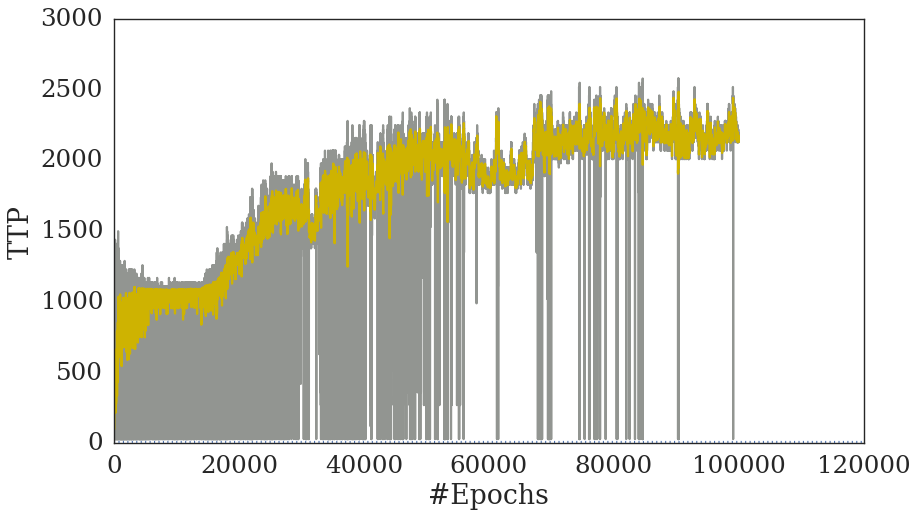

In [6]:
plot_trainingPerformance(model_id=model_name, model_path=model_path, var_to_plot='TTP',
                         lineYPos=10, figsize=(12,7))#, saveFig = True, outName = "../images/drl_performance/training_progression_%s" % model_id)
# plt.xticks([0, 100000, 200000])
# plt.xlabel("Epoch Number")
# plt.savefig("../images/drl_performance/training_progression_%s.png" % model_id)

### Evaluate on training patient (Patient 25)

In [17]:
# ODE params for model trained on patient 25
trainingDataDf = pd.read_csv("../models/trainingPatientsDf_bruchovsky.csv", index_col=0)
trainingDataDf = trainingDataDf[trainingDataDf.PatientId==25]
odeParamDic = convert_ode_parameters(trainingDataDf['n0'].values[0],trainingDataDf['fR'].values[0],
                                     trainingDataDf['cost'].values[0],trainingDataDf['turnover'].values[0])

In the next cell, we evaluate the deep learning model. This is non-trivial, as it requires the deep learning model to be executed in the dedicated virtual environment, which is not used for the kernel of this notebook. The following code therefore generates a `params.json` file with the necessary parameters for the execution of this evaluation, and then generates a terminal command for it. The path to the python executable in the dedicated DRL virtual environment should be assigned to the variable `DRL_env` at the top of the file.

In some operating systems, this can then be executed directly from the notebook using the subprocess module, and the cell below can be run normally. However, in other cases this command throws an error, and cannot be used. In this case, the simplest work-around is simply to copy and paste the command (which is printed below the cell) into the terminal, and run it directly there. Note that the cell below will throw an error until that has been completed, as it relies on the output file having been generated. If multiple epoch numbers have been specified, it will be necessary to repeat this process multiple times (each time for the new command that has been printed) before the cell executes without error.

In [22]:
DRL_env = ""  # README: Insert the path to the python executable within the DRL environment here

for n_epochs in epoch_list:
    currModel_path = os.path.join("../models/",model_name, "%d_patients_%s"%(n_epochs, model_name))
    results_file_name = 'resultsDf_%s_%d_patients.csv'%(model_name,n_epochs)
    argDic = {'model_path':currModel_path, 'patients_to_evaluate':pd.DataFrame([{**odeParamDic,'PatientId':25}]).to_dict(), 
              'n_replicates':n_replicates, 'updating_interval':1, #updating_interval,
              'results_path':results_path, 'results_file_name':results_file_name,
              'verbose':0, 'tqdm_output':os.path.join(results_path,"log_currentSizeOnly_p25.txt")}
    
    # To run the DRL we need tensorflow 1.5 which is not compatible with Python >3.6. To be able 
    # to run it I made a separate environment. Use an external script to run the evaluation in that
    # environment.
    if runFromScratch:
        with open("params/params_p25_%s.json"%(n_epochs), "w") as outfile:
            json.dump(argDic, outfile)
        command = DRL_env + " run_evaluation.py params/params_p25_%s.json"%(n_epochs)
        print(command)

        # Run the command
        # p = subprocess.run(command, capture_output=True, shell=True)
        # print(p.returncode, p.stdout, p.stderr)
        # if p.returncode==0:
        #     os.remove("params/params_%s.json"%(n_epochs))
        #     print("Run completed successfully")

        # Load results and process them
        dataDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
        # Extract TTP information
        tmpList = []
        for replicateId in dataDf_currSizeOnly_step1.ReplicateId.unique():
            ttp = dataDf_currSizeOnly_step1[dataDf_currSizeOnly_step1.ReplicateId==replicateId].Time.max()
            tmpList.append({"Model":"currSizeOnly_step1", "ReplicateId":replicateId, "TTP":ttp})
        ttpDf_currSizeOnly_step1 = pd.DataFrame(tmpList)
        ttpDf_currSizeOnly_step1.to_csv(os.path.join(results_path,"ttpDf_%s_p25_%d_patients.csv"%(model_name,n_epochs)))
    else:
        # Load results
        dataDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
        ttpDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,"ttpDf_%s__p25_%d_patients.csv"%(model_name,n_epochs)), index_col=0)


/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py params/params_p25_5000.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py params/params_p25_25000.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py params/params_p25_100000.json


In [ ]:
# Compute performance under rule of thumb
model = LotkaVolterraModel(method='RK45')
model.SetParams(**odeParamDic)
model.Simulate_AT(atThreshold=0.5, intervalLength=updating_interval, t_end=5000);
model.Trim(dt=1)

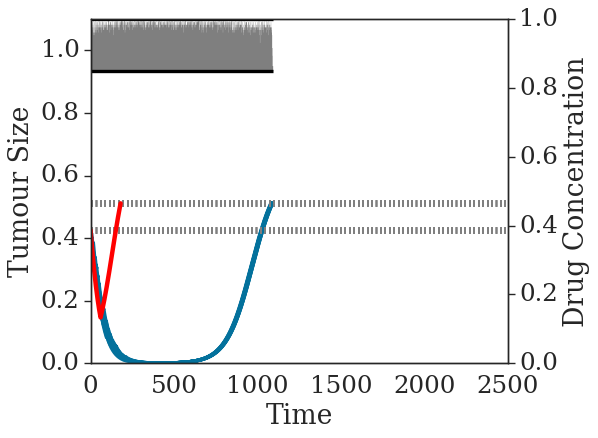

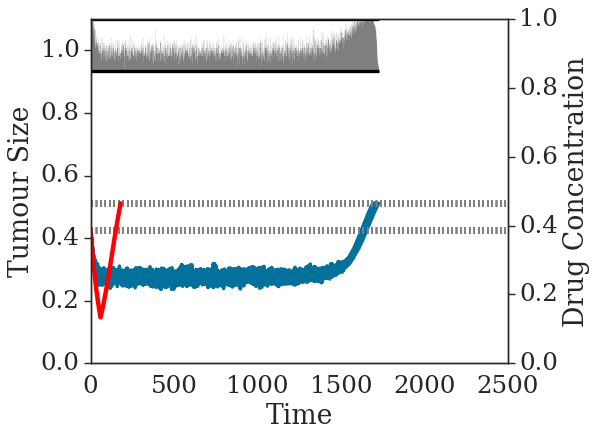

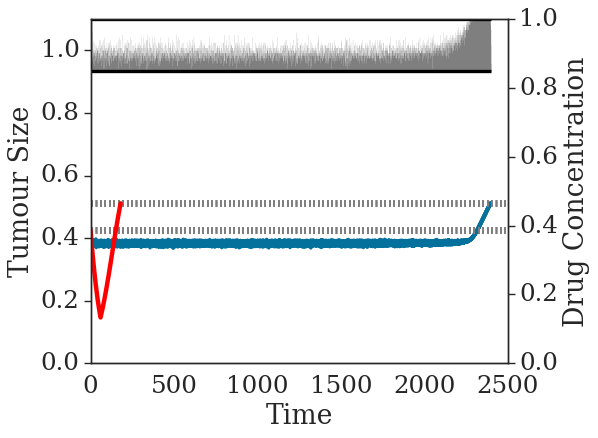

In [23]:
for n_epochs in epoch_list:
    results_file_name = 'resultsDf_%s_%d_patients.csv'%(model_name,n_epochs)
    currDataDf = pd.read_csv(os.path.join(results_path,results_file_name))
    # Plot average trajectories
    fix, ax = plt.subplots(1,1,figsize=(8,6))
    plot_simulation(currDataDf, plotPops=False, lineplot_kws={'estimator':None, 'units':"ReplicateId"},
                    markInitialSize=True, markProgression=True, xlim=[0,2.5e3], ylim=[0,1.1], ax=ax)
    ax.plot(model.resultsDf.Time, model.resultsDf.TumourSize, lw=4, color='red')

In [24]:
print("Mean ttp is %s days" % (np.mean(ttpDf_currSizeOnly_step1.TTP)))

Mean ttp is 2396.4 days


### Analyse learned policy

In [25]:
tmpList = []
for n_epochs in epoch_list:
    results_file_name = 'resultsDf_%s_%d_patients.csv'%(model_name,n_epochs)
    currDataDf = pd.read_csv(os.path.join(results_path,results_file_name))
    currDataDf['TumourSize'] /= currDataDf['TumourSize'].iloc[0]
    currDataDf['n_epochs'] = n_epochs
    tmpList.append(currDataDf)
policyDf = pd.concat(tmpList)

(0.0, 1.2)

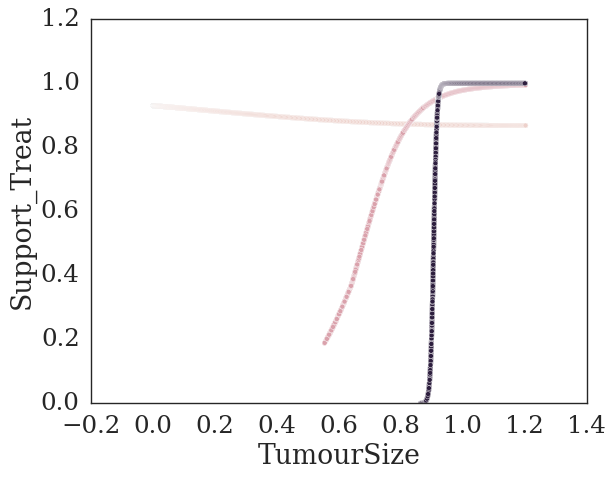

In [26]:
# Plot learned policies
fix, ax = plt.subplots(1,1,figsize=(8,6))
sns.scatterplot(x='TumourSize', y='Support_Treat', hue="n_epochs", legend=False, data=policyDf, ax=ax)
ax.set_ylim(0,1.2)